# Querying PostgreSQL / PostGIS Databases in Python

### Introduction and Spatial Database Background

In the following notebook, I show how to build a PostgreSQL relational database with the PostGIS extension that supports spatial databases. I'll use the ```psycopg2``` Python module to access the database and import data, manipulate data, make a query, and then extract the data. I do a lot of data wrangling, analysis, and visualization using Python and find it really nice and efficient to be able to access and query SQL databases within the same environment!

In this example I will perform simple spatial query. This methodology is much more efficient with large datasets than using ```Shapely``` or ```Geopandas``` to make spatial queries because the entire dataset does not have to be loaded into memory and the entire dataset does not need to be searched when a spatial query is made. Spatial databases uses spatial indices to optimize spatial queries. A spatial index is efficient because rather than indexing the geometry directly, it calculates the minimum bounding rectangle for each geometry, and indexes that bounding box. When a query is made, the database first identifies the potentially matching records using the bounding rectangles stored in the spatial index and then loads each potential geometry into memory to check it.

In this example I populate a database with the contents from a shapefile of census blocks in San Francisco and then query those blocks that have non-zero population values and their centroid within the Inner Richmond neighborhood in San Francisco. I then extract the results of this query into a GeoPandas dataframe.

### Installing PostgreSQL with PostGIS Extension
The first step is to get PostgreSQL and the PostGIS extension installed. Windows versions of PostgreSQL can be downloaded here: http://www.enterprisedb.com/products-services-training/pgdownload#windows

When following the installation steps, there will be an option to install PostGIS. Make sure to check this box.

Once you have PostGIS and PostgreSQL installed, you need to make sure that the Windows path variable includes the "bin" folder of the Postgres installation, if you want to be able to execute Postgres functions from the command line. For my installation, that is located here: ```C:\Program Files (x86)\PostgreSQL\9.5\bin```

This can also be done temporarily from within the command line with: 
```
set PATH=%PATH%;C:\Program Files (x86)\PostgreSQL\9.5\bin
```

### Creating Spatial Database from Command Line

The next steps are to create the new database with the PostGIS extension. From the command line, I run the following two commands to create my database called "ca_blocks:
```
createdb -U postgres ca_blocks
psql -U postgres -d ca_blocks -c "CREATE EXTENSION postgis;"
```

I then install ```psycopg2``` using the pip Python package manager and am all ready to go! 


```pip install psycopg2```

## Connecting to the Database from Python using ```psycopg2```
I first need to install necessary modules: ```psycopg2``` for connecting to the database, ```osgeo``` for reading in shapefiles, ```shapely``` to convert between different geography formats, and ```geopandas``` to store my final set of ```shapely``` geometries. 

I downloaded the Census Block File with population values from [Census TIGER/Line](https://www.census.gov/geo/maps-data/data/tiger-data.html) and a shapefile of San Francisco neighborhoods from the city's [data portal](https://data.sfgov.org/).

In [1]:
import psycopg2
import osgeo.ogr
import shapely
import shapely.wkt
import geopandas as gpd
%matplotlib inline

Now that I have everything installed and my database is created, the first step is to connect to the database and set up a cursor object which is used to issue commands.

In [2]:
connection = psycopg2.connect(database="AkashV1",user="postgres", password="chaotickarma6251")
cursor = connection.cursor()


### Creating an Empty Table in the Database
Next I create a table within my database called "blocks" with 4 fields, each of a different type. However, before I do that, I'm going to delete the table if it already exists, just so I can run the code multiple times without causing any errors. The 4 fields I create are an ID field which is automatically allocated by the database; a field "fips" that holds the block FIPS code; a field "pop" that holds the population value of that block; and a field "outline" which holds the geography. Note that I am using the "GEOGRAPHY" field type, which is just a variant of the "GEOMETRY" field type. "GEOGRAPHY" fields hold unprojected lat/long coordinates as my shapefile contains. This could be projected and converted to a "GEOMETRY" field, but for this example I choose to stay with the "GEOGRAPHY" type.

In [3]:
cursor.execute("DROP TABLE IF EXISTS blocks")
cursor.execute("CREATE TABLE blocks (id SERIAL PRIMARY KEY, fips VARCHAR NOT NULL, pop BIGINT NOT NULL, outline GEOGRAPHY)")

Next I create a spatial index for the outline field, which is necessary to make efficient spatial queries. Then I commit the changes to my database.

In [4]:
cursor.execute("CREATE INDEX block_index ON blocks USING GIST(outline)")
connection.commit()

### Populating the Database with Spatial Data

Now I use the GDAL/OGR library to read in the shapefile of San Francisco census blocks and add the contents of this shapefile to my newly created database. I loop through each feature in the shapefile and extract the FIPS code, population value, and geometry. Note, that I use the well-known text (WKT) format to transfer geometries from one format to another. The WKT format is just a string representation of a geometry that can easily be converted. In this example it serves as the bridge between the OGR geometry format and the PostGIS format. 

I use ```cursor.execute()``` to run a SQL command that converts the Python values to SQL string literals. There is an additional conversion for the geometry value where the ```ST_GeoFromText``` function is used to convert the WKT format to a PostGIS geography.

In [5]:
shapefile = osgeo.ogr.Open("Data/sf_blocks.shp")
layer = shapefile.GetLayer(0)

#First delete the existing contents of this table in case we want to run the code multiple times.
cursor.execute("DELETE FROM blocks")

for i in range(layer.GetFeatureCount()):
    feature = layer.GetFeature(i)
    fips = feature.GetField("BLOCKID10")
    pop = feature.GetField("POP10")
    #Get feature geometry
    geometry = feature.GetGeometryRef()
    #Convert geometry to WKT format
    wkt = geometry.ExportToWkt()
    #Insert data into database, converting WKT geometry to a PostGIS geography
    cursor.execute("INSERT INTO blocks (fips, pop, outline) VALUES ({}, {}, ST_GeogFromText('{}'))".format(fips, pop, wkt))
connection.commit()    


### Manipulating the Database and Calculating New Columns

Next, I'm going to manipulate the spatial database and add a new geography that will hold the centroid value of each census block. This will be done so we can later make a query based on centroid location. I nest the SQL command in a try / except statement so  that we can catch the programming error that will come up if we run the script more than once and try to create a column that already exists.

In [6]:
try:
    cursor.execute("ALTER TABLE blocks ADD COLUMN centroid GEOGRAPHY")
except psycopg2.ProgrammingError:
    connection.rollback

In the following SQL statement I update the spatial dataset and set the centroid field equal to the result from the ```ST_Centroid``` function. Notice that with the ```ST_Centroid``` function, in addition to telling it to calculate the centroid on the outline geography field, I also have to include ```::geometry```, which casts the geography type to a geometry type. This is because the ```ST_Centroid``` function works on geometry fields, not geography fields (these kind of calculations require a projected coordinate system). However, what I'm doing here is telling it to just treat my unprojected coordinate system as if it were projected. This is not a big deal in this case because we are working over such a small area, where a calculation that treats degrees as if they were projected will not make much of a difference in terms of centroid location. If I were working over a larger area, it would be better to use a geometry type from the beginning and then use ```ST_Transform``` to transform the data into a projected coordinate system that applies to California.

In [7]:
cursor.execute("UPDATE blocks SET centroid=ST_Centroid(outline::geometry)")
connection.commit()    

### Reading in and Manipulating Other Spatial Data to Make Queries

Now I will read the shapefile of SF neighborhoods. In this case, rather than reading in the data with GDAL/OGR, I will read it in with Geopandas, which will provide me with a really easy way to extract the geometry for the Inner Richmond, the neighborhood that I'm interested in for this example.

In [8]:
sf_neighs=gpd.read_file('Data/SFFind_Neighborhoods.shp').set_index('name')['geometry']
sf_neighs.head()

name
Seacliff                  POLYGON ((-122.4934552679999 37.78351817100008...
Lake Street               POLYGON ((-122.4871507149999 37.78378542700005...
Presidio National Park    POLYGON ((-122.4775801709999 37.81099311300005...
Presidio Terrace          POLYGON ((-122.4724105299999 37.78734653900005...
Inner Richmond            POLYGON ((-122.4726257899999 37.78631480600006...
Name: geometry, dtype: object

As I did earlier, I will convert the Shapely geometry object to a WKT so that it can be converted to a PostGIS geography.

In [10]:
inner_richmond_wkt=shapely.wkt.dumps(sf_neighs['Inner Richmond'])
print (inner_richmond_wkt)

POLYGON ((-122.4726257899999382 37.7863148060000640, -122.4668303349999405 37.7865681350000386, -122.4666944429999376 37.7847155220000559, -122.4591787659999227 37.7856816910000362, -122.4583710989999190 37.7743088950000470, -122.4651708719999306 37.7734429910000813, -122.4658831629999440 37.7733982040000456, -122.4777669469999068 37.7728636550000374, -122.4785619299998984 37.7841768850000790, -122.4725858689999427 37.7844488900000783, -122.4726257899999382 37.7863148060000640))


### Make a Spatial Query

Next I execute an SQL command that queries the database with two criteria - one spatial and one non-spatial. I look for those records that have a centroid within the Inner Richmond neighborhood and have a population value greater than 0. Again, the Inner Richmond WKT is converted to a PostGIS geography using ```ST_GeomFromText```, and the ```ST_Intersects``` tool is used to identify those blocks who's centroid intersect this geography. I extract the FIPS code, the population and value, and the geography, which I first convert to WKT using ```ST_AsText```

In [11]:
cursor.execute("SELECT fips,pop,ST_AsText(outline) FROM blocks "+\
"WHERE ST_Intersects(ST_GeomFromText('{}'), centroid) ".format(inner_richmond_wkt)+\
"AND POP>0")

### Extract Data from Database and Convert to GeoDataFrame

Now, I want to get my data out of PostGIS. I loop through the records in the cursor, and store them as a list of dictionaries. This puts them in a format that can easily be read in by Pandas/Geopandas. Note that I specify that the geometry is in the WGS84 spatial reference system because Shapely geometries do not inherently have any spatial reference.

In [12]:
rows_list=[]
for fips,pop,geo in cursor:
    data={'FIPS':fips,'POP':pop,'geometry':shapely.wkt.loads(geo)}
    rows_list.append(data)
gdf=gpd.GeoDataFrame(rows_list,crs='epsg:4326').set_index('FIPS')
gdf.head()

,POP,geometry
FIPS,,
60750476002001,246,"POLYGON ((-122.472708 37.778704, -122.472572 3..."
60750476002002,176,"POLYGON ((-122.473833 37.778653, -122.473698 3..."
60750402002005,1,"POLYGON ((-122.471915 37.782596, -122.471775 3..."
60750402002003,285,"POLYGON ((-122.469627 37.780769, -122.469757 3..."
60750401002002,39,"POLYGON ((-122.461369 37.785403, -122.461336 3..."


I can then really easily get the number blocks and number of people in the Inner Richmond neighborhood, as well as make a quick map of my data using the built in plot feature of Geopandas. Here I symbolize the blocks based on population values divided into quantiles. Note the missing data where there was no population and were therefore not queried in the PostGIS database.

In [14]:
print ('There are '+str(len(gdf)) +' census blocks in the Inner Richmond Neighborhood, \
representing a populaton of ' + str(gdf.POP.sum()))

There are 118 census blocks in the Inner Richmond Neighborhood, representing a populaton of 24635


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\geopandas\plotting.py:396: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


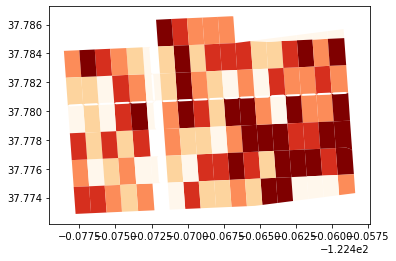

In [16]:
gdf.plot(column='POP', scheme='QUANTILES', k=5, colormap='OrRd')

### Conclusion

This was a pretty basic example that shows how to set up and populate spatial databases to make spatial and non-spatial queries. The ```psycopg2``` modules makes it really easy to execute SQL commands from within Python, which is nice if you do all of your other work in Python like I do.

One potential point of confusion is all of the different geometry types used. Even in this small script, we worked with 5 different geometry types - Shapefiles, OGR, WKT, PostGIS, and Shapely. Basically these are all used as a way to link Shapefiles (our native format in this case) to PostGIS (the format that the analysis is done in) to a Geopandas Dataframe storing Shapely geometries (our output). The well-known text type is the key way to link these together.

I hope this was helpful in showing how to access spatial databases in Python!